In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


### Create dataset

In [23]:
samples = 1500
X, Y = make_circles(samples, noise = 0.04)

In [24]:
X.shape, Y.shape

((1500, 2), (1500,))

In [25]:
# convert to pandas dataframe
df = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'Label': Y})

In [26]:
df.head()

,X1,X2,Label
0,-0.943016,0.024676,0
1,-0.703622,-0.087522,1
2,0.242077,-0.811539,1
3,0.208665,-0.811657,1
4,0.741159,-0.296545,1


In [ ]:
# check the distribution of labels
df.Label.value_counts()

Label
0    750
1    750
Name: count, dtype: int64

Nicely balanced dataset, no rare labels.

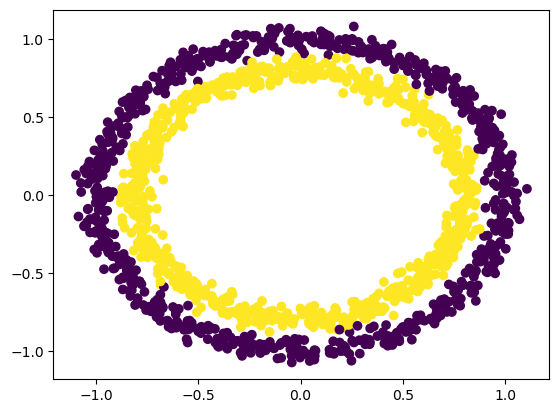

In [27]:
plt.scatter(x = df['X1'], y = df['X2'], c = df["Label"])

In [28]:
type(X)

numpy.ndarray

In [ ]:
# convert to torch tensors
X = torch.from_numpy(X).type(torch.FloatTensor)
Y = torch.from_numpy(Y).type(torch.FloatTensor)

In [30]:
type(X), type(Y)

(torch.Tensor, torch.Tensor)

In [42]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y,
                                                    test_size=.20,
                                                    random_state=42)

In [44]:
train_X[:5], train_Y[:5]

(tensor([[ 0.2201,  1.0015],
         [ 0.2598,  1.0808],
         [ 0.7324,  0.3446],
         [-0.8240, -0.0755],
         [ 0.2594,  0.7725]]),
 tensor([0., 0., 1., 1., 1.]))

### Build the model

In [4]:
class CircularLinNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features= 6)
        self.layer_2 = nn.Linear(in_features=6, out_features=1)

    def forward(self, X):
        return self.layer_2(self.layer_1(X))
    
# create instance and load on device
model_C = CircularLinNN().to(device)
model_C.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.6644, -0.0158],
                      [-0.6686, -0.2659],
                      [-0.6148, -0.4087],
                      [ 0.0626,  0.4230],
                      [ 0.2317,  0.2691],
                      [-0.6347, -0.0964]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.5172,  0.6797, -0.3702, -0.4617,  0.4620, -0.0665], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.1113,  0.1325,  0.3434,  0.2237, -0.0979,  0.1783]],
                     device='cuda:0')),
             ('layer_2.bias', tensor([-0.0571], device='cuda:0'))])